<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Прогнозирование количества заказов такси на следующий час

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [38]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

## Подготовка

In [39]:
# загрузка данных
try:
    taxi = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0]) # Локальный путь
except:
    taxi = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) # Сервесный путь 

In [40]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [41]:
# ресемплинг данных
taxi = taxi.resample('1H').sum()

taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Text(0.5, 1.0, 'Количесво заказов такси')

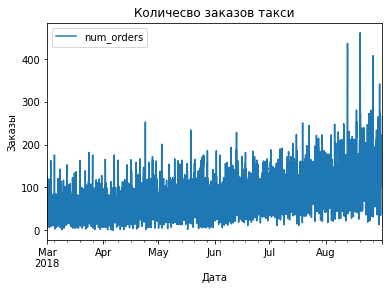

In [42]:
taxi.plot()
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.title('Количесво заказов такси')

## Анализ

Разложим данные на тренд, сезонность и остатки.

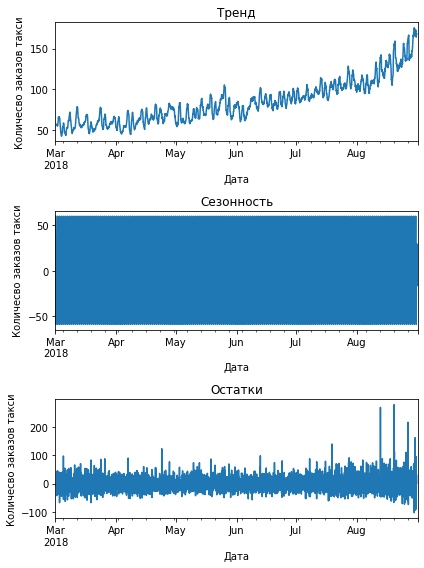

In [43]:
decomposed_taxi = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))

plt.subplot(3,1,1)
decomposed_taxi.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')

plt.subplot(3,1,2)
decomposed_taxi.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')

plt.subplot(3,1,3)
decomposed_taxi.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')
plt.tight_layout()

В данных виден явно восходящий тренд -- за полгода количесво заказов такси увеличилось примерно в 3 раза.

Уменьшим временной интервал (возьмем только одну неделю августа), чтобы посмотреть на сезонность.

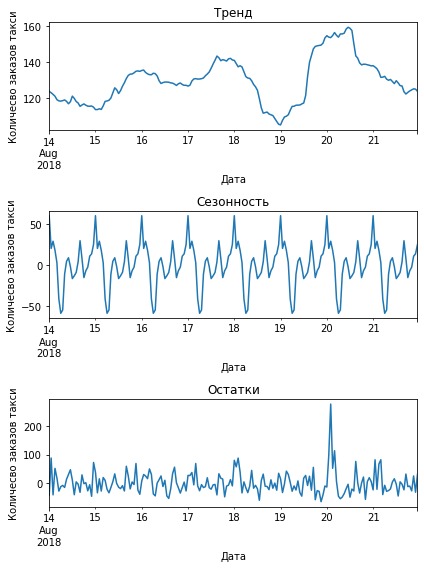

In [44]:
#decomposed_taxi = seasonal_decompose(taxi['2018-08-14':'2018-08-21'])

plt.figure(figsize=(6, 8))

plt.subplot(3,1,1)
decomposed_taxi.trend['2018-08-14':'2018-08-21'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')

plt.subplot(3,1,2)
decomposed_taxi.seasonal['2018-08-14':'2018-08-21'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')

plt.subplot(3,1,3)
decomposed_taxi.resid['2018-08-14':'2018-08-21'].plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')
plt.tight_layout()

Сезонность имеет период одного дня. Видны ночные пики вызовов такси и утренняя просадка.

## Обучение

Создадим необходимые для  обучения признаки

In [45]:
# создание признаков
def make_features(data, max_lag, rolling_mean_size):
    # создание нового датафрейма
    data_new = data.copy()
    
    # календарные признаки
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    # "отстающие значения"
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    # скользащее среднее
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new

In [46]:
taxi_new = make_features(taxi, 9, 4)

In [47]:
taxi_new.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,86.5


In [49]:
# разделим данные на обучающую и тестовую выборки
train, valid = train_test_split(taxi_new, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)

In [50]:
# удалим строки с NaN
train = train.dropna()

In [51]:
# разобьем на признаки и целевой признак
features_train = train.drop(['num_orders'],axis=1)
target_train = train['num_orders']

features_valid = test.drop(['num_orders'],axis=1)
target_valid = test['num_orders']

features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

In [52]:
# Проверка на соответсвие размеров выборок
print('Размер тестовой выборки:')
print('features_test:',features_test.shape)
print('target_test:',target_test.shape)

print()
print('Размер валидационной выборки:')
print('features_valid:',features_valid.shape)
print('target_valid:',target_valid.shape)

print()
print('Размер обучающей выборки:')
print('features_train:',features_train.shape)
print('target_train:',target_train.shape)

Размер тестовой выборки:
features_test: (442, 15)
target_test: (442,)

Размер валидационной выборки:
features_valid: (442, 15)
target_valid: (442,)

Размер обучающей выборки:
features_train: (3523, 15)
target_train: (3523,)


In [53]:
# Линейная регрессия

model_lin = LinearRegression()
model_lin.fit(features_train, target_train)

prediction_train_lin = model_lin.predict(features_train)
prediction_valid_lin = model_lin.predict(features_valid)

rmse_train_lin = mean_squared_error(target_train, prediction_train_lin, squared=False)
rmse_valid_lin = mean_squared_error(target_valid, prediction_valid_lin, squared=False)

print("RMSE обучающей выборки:", rmse_train_lin)
print("RMSE валидационной выборки: ", rmse_valid_lin)

RMSE обучающей выборки: 28.73860663902889
RMSE валидационной выборки:  54.430373399999645


In [54]:
# DecisionTreeRegressor
def best_papameters_tree(features_train,target_train,features_valid,target_valid):
    best_model_tree = None
    best_score_tree = 1_000_000
    best_depth_tree = 0
    for depth in range(1, 20):
        model_tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
        model_tree.fit(features_train,target_train)
        prediction_tree = model_tree.predict(features_valid)
        score_tree = mean_squared_error(target_valid,prediction_tree,squared=False)
        
        if score_tree < best_score_tree:
            best_model_tree = model_tree
            best_score_tree = score_tree
            best_depth_tree = depth
    return best_depth_tree

In [55]:
best_depth_tree = best_papameters_tree(features_train,
                                       target_train,
                                       features_valid,
                                       target_valid)

print(best_depth_tree)

model_tree = DecisionTreeRegressor(random_state=12345, max_depth=best_depth_tree)
model_tree.fit(features_train,target_train)

prediction_train_tree = model_tree.predict(features_train)
prediction_valid_tree = model_tree.predict(features_valid)

rmse_train_tree = mean_squared_error(target_train, prediction_train_tree, squared=False)
rmse_valid_tree = mean_squared_error(target_valid, prediction_valid_tree, squared=False)

print("RMSE обучающей выборки:", rmse_train_tree)
print("RMSE валидационной выборки: ", rmse_valid_tree)

11
RMSE обучающей выборки: 13.176724035324325
RMSE валидационной выборки:  54.6601983364689


In [56]:
# RandomForestRegressor
def best_papameters_forest(features_train,target_train,features_valid,target_valid):
    best_model_forest = None
    best_score_forest = 100000
    best_est_forest = 0
    best_depth_forest = 0
    for est in range(1, 20):
        for depth in range (1, 20):
            model_forest = RandomForestRegressor(random_state=12345, n_estimators=est,max_depth=depth)
            model_forest.fit(features_train,target_train)
            prediction_forest = model_forest.predict(features_valid)
            score_forest = mean_squared_error(target_valid,prediction_forest,squared=False)
            if score_forest < best_score_forest:
                best_model_forest = model_forest
                best_score_forest = score_forest
                best_est_forest = est
                best_depth_forest = depth
    return best_depth_forest,best_est_forest

In [57]:
best_depth_forest,best_est_forest = best_papameters_forest(features_train,
                                                           target_train,
                                                           features_valid,
                                                           target_valid)

print(best_depth_forest,best_est_forest)

model_forest = RandomForestRegressor(random_state=12345, n_estimators=best_est_forest,max_depth=best_depth_forest)
model_forest.fit(features_train,target_train)

prediction_train_forest = model_forest.predict(features_train)
prediction_valid_forest = model_forest.predict(features_valid)

rmse_train_forest = mean_squared_error(target_train, prediction_train_forest, squared=False)
rmse_valid_forest = mean_squared_error(target_valid, prediction_valid_forest, squared=False)

print("RMSE обучающей выборки:", rmse_train_forest)
print("RMSE валидационной выборки: ", rmse_valid_forest)

15 8
RMSE обучающей выборки: 10.504041972616312
RMSE валидационной выборки:  47.09108031082007


## Тестирование

Проверим модели на тестовой выборке

In [58]:
prediction_test_lin = model_lin.predict(features_test)
rmse_test_lin = mean_squared_error(target_test, prediction_test_lin, squared=False)
print("RMSE тестовой выборки: ", rmse_test_lin)

RMSE тестовой выборки:  54.430373399999645


In [59]:
prediction_test_tree = model_tree.predict(features_test)
rmse_test_tree = mean_squared_error(target_test, prediction_test_tree, squared=False)
print("RMSE тестовой выборки: ", rmse_test_tree)

RMSE тестовой выборки:  54.6601983364689


In [60]:
prediction_test_forest = model_forest.predict(features_test)
rmse_test_forest = mean_squared_error(target_test, prediction_test_forest, squared=False)
print("RMSE тестовой выборки: ", rmse_test_forest)

RMSE тестовой выборки:  47.09108031082007


In [61]:
#score_tabel
score_table = {
    'model':['linear_regression', 'desidion_tree', 'random_forest'],
    'score_train':[rmse_train_lin, rmse_train_tree, rmse_train_forest],
    'score_valid':[rmse_valid_lin, rmse_valid_tree, rmse_valid_forest],
    'score_test':[rmse_test_lin, rmse_test_tree, rmse_test_forest]
}

df_score_table = pd.DataFrame(score_table)

df_score_table.set_index('model',inplace=True)
df_score_table = df_score_table.transpose()

df_score_table

model,linear_regression,desidion_tree,random_forest
score_train,28.738607,13.176724,10.504042
score_valid,54.430373,54.660198,47.091080
score_test,54.430373,54.660198,47.091080


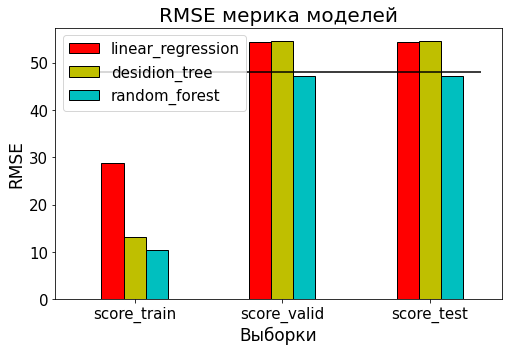

In [62]:
# устанавливаем некоторые параметры рисунка
plt.figure(figsize=[8, 5])
wd = 0.3
x_pos = np.arange(1, 2*len(df_score_table), 2)

# Рисуем столбчатую диаграму
plt.bar(x_pos, df_score_table['linear_regression'], color='r', width=wd, edgecolor='k',
        label='linear_regression')
plt.bar(x_pos+wd, df_score_table['desidion_tree'], color='y', width=wd, edgecolor='k', 
        label='desidion_tree')
plt.bar(x_pos+(wd*2), df_score_table['random_forest'], color='c', width=wd, 
        edgecolor='k', label='random_forest')

plt.hlines(48, 0.5, 6, color = 'black')

# Добавляем подписи
plt.xticks(x_pos+wd, df_score_table.index.values, fontsize=15)
plt.yticks(fontsize=15)
plt.title('RMSE мерика моделей', fontsize=20)
plt.xlabel('Выборки', fontsize=17)
plt.ylabel('RMSE', fontsize=17)

plt.legend(loc='upper left', fontsize=15)
plt.show()

In [86]:
df_prediction_test = pd.DataFrame({"num_order_init":target_test,
                                   "num_order_lin":prediction_test_lin,
                                   "num_order_tree":prediction_test_tree,
                                   "num_order_forest":prediction_test_forest,}, index=target_test.index)

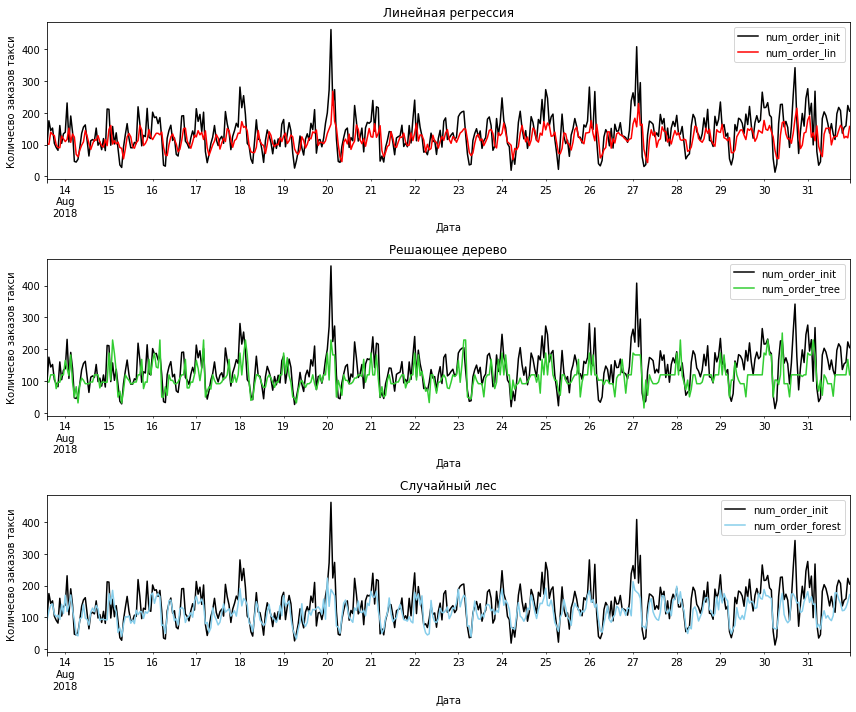

In [103]:
#df_prediction_test[['num_order_init','num_order_lin']].plot()

plt.figure(figsize=(12, 10))

plt.subplot(3,1,1)
df_prediction_test[['num_order_init','num_order_lin']].plot(ax=plt.gca(), color=['black', 'red'])
plt.title('Линейная регрессия')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')

plt.subplot(3,1,2)
df_prediction_test[['num_order_init','num_order_tree']].plot(ax=plt.gca(), color=['black', 'limegreen'])
plt.title('Решающее дерево')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')

plt.subplot(3,1,3)
df_prediction_test[['num_order_init','num_order_forest']].plot(ax=plt.gca(), color=['black', 'skyblue'])
plt.title('Случайный лес')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')
plt.tight_layout()

**Вывод**

Для предсказания количества заказов такси были обучены и проанализированы несколько моделей машинного обучения:
- Решающее дерево
- Линейная регрессия
- Случайный лес

Модели сравнивались по метрике RMSE.

Наилучший результат показала модель случайного леса.

    RMSE = 47.09
